# TP2 - DB Normalization and Querying

The objectives of this TP are:
1. Apply normalization 1NF -> 2NF -> 3NF
2. Perform SQL queries on the normalized database

In this TP, we will use a database **`wine.db`** (available in the course's website) containing wine information related to 'production' and 'sales'. 

> Production <---> Wine <---> Sales


---

### Working with db files in Jupyter
- Python provides an interface for SQLite through the *sqlite3* module
- The **`%%sql`** magic builds upon it (and other tools) to enable the usage of SQL commands within a Jupyter Notebook as in common SQL clients.
- Before proceeding, make sure that **`wine.db`** is in the same path as this notebook.
  - If **`wine.db`** is not in the same path, an empty **`wine.db`** file will be created, resulting in errors in later steps of the TP.
- The SQLite module in Python commits transactions automatically, this means that any change in the DB is immediately written to the file, e.g. creating/deleting tables.
  -  For this reason, it is recommended to have a backup of **`wine.db`** as it is provided in the course's website.

---

**`wine.db`** contains the following unnormalized tables:

<center>**Master1**</center>

|*Attribute*|         *Description*          |
| -------   |--------------------------------|
| NV        | Wine number                    |
| CRU       | Vineyard or group of vineyards |
| DEGRE     | Alcohol content                |
| MILL      | Vintage year                   |
| QTE       | Number of bottles harvested    |
| NP        | Producer number                |
| NOM       | Producer's last name           |
| PRENOM    | Producer's first name          |
| REGION    | Production region              |

From wikipedia:

__Cru__: Often used to indicate a specifically named and legally defined vineyard or ensemble of vineyards and the vines "which grow on [such] a reputed terroir; by extension of good quality." The term is also used to refer to the wine produced from such vines.


<center>**Master2**</center>

|*Attribute*|                         *Description*                  |
| -------   |--------------------------------------------------------|
| NV        | Wine number                                            |
| CRU       | Vineyard or group of vineyards                         |
| DEGRE     | Alcohol content                                        |
| MILL      | Vintage year                                           |
| DATES     | Buying date                                            |
| LIEU      | Place where the wine was sold                          |
| QTE       | Number of bottles bought                               |
| NB        | Client (buveur) number                                 |
| NOM       | Client's last name                                     |
| PRENOM    | Client's first name                                    |
| TYPE      | Type of client by volume of purchases                  |
| REGION    | Administrative Region (different to production region) |


In [1]:
import sqlite3    # Python interface for SQLite databases

In [35]:
def printSchema(connection):
    # Function to print the DB schema
    # Source: http://stackoverflow.com/a/35092773/4765776
    for (tableName,) in connection.execute(
        """
        select NAME from SQLITE_MASTER where TYPE='table' order by NAME;
        """
    ):
        print("{}:".format(tableName))
        for (
            columnID, columnName, columnType,
            columnNotNull, columnDefault, columnPK,
        ) in connection.execute("pragma table_info('{}');".format(tableName)):
            print("  {id}: {name}({type}){null}{default}{pk}".format(
                id=columnID,
                name=columnName,
                type=columnType,
                null=" not null" if columnNotNull else "",
                default=" [{}]".format(columnDefault) if columnDefault else "",
                pk=" *{}".format(columnPK) if columnPK else "",
            ))

In [47]:
conn = sqlite3.connect('wine.db')
c = conn.cursor()
print("Database schema:")
printSchema(conn)           # An usefull way to viualize the content of the database

Database schema:
Buyer:
  0: NB(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: TYPE(TEXT)
Location:
  0: LIEU(TEXT)
  1: REGION(TEXT)
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)
Producer:
  0: NP(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: REGION(TEXT)
Production:
  0: NP(NUM)
  1: NV(NUM)
  2: QTE(NUM)
Sales:
  0: NB(NUM)
  1: NV(NUM)
  2: DATES(NUM)
  3: LIEU(TEXT)
  4: QTE(NUM)
Wine:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
Wine_bought:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
dummy:
  0: DEGRE(NUM)


From this point we will use __%%sql__ magic

In [4]:
%load_ext sql
%sql sqlite:///wine.db

'Connected: @wine.db'

# PART I: Database normalization

The first task on this TP is the normalization of the wine data. In its current state both tables **Master1** and **Master2** are in the First Normal Form (1NF).

By inspecting the content of these tables we can see that multiple tuples have NULL values.

In [5]:
%%sql SELECT *
FROM Master1
LIMIT 10;

 * sqlite:///wine.db
Done.


NV,CRU,DEGRE,MILL,QTE,NP,NOM,PRENOM,REGION
None,None,None,None,None,3,Six,Paul,Alsace
None,None,None,None,None,6,Marmagne,Bernard,Bourgogne
None,None,None,None,None,8,Lioger d'Harduy,Gabriel,Bourgogne
None,None,None,None,None,16,Barbin,Bernard,Bourgogne
None,None,None,None,None,17,Faiveley,Guy,Bourgogne
None,None,None,None,None,18,Tramier,Jean,Bourgogne
None,None,None,None,None,19,Dupaquier,Roger,Bourgogne
None,None,None,None,None,20,Lamy,Jean,Bourgogne
None,None,None,None,None,21,Cornu,Edmond,Bourgogne
None,None,None,None,None,26,Violot,Gilbert,Bourgogne


* Notice that Jupyter *displays* 'None' instead of 'NULL'. 
  - This is only to comply with python notation.
* To account for NULL values, your SQL queries must test explicitly for 'NULL'.

Another problem in **Master1** and **Master2** is data redundancy, for example:

In [6]:
%%sql SELECT *
FROM Master1
WHERE NV = 45;

 * sqlite:///wine.db
Done.


NV,CRU,DEGRE,MILL,QTE,NP,NOM,PRENOM,REGION
45,Chiroubles,None,1983,90,2,Boxler,Albert,Alsace
45,Chiroubles,None,1983,912,67,Descombes,Jean Ernest,Beaujolais
45,Chiroubles,None,1983,98,71,Chalandard,Danile,Jura
45,Chiroubles,None,1983,540,78,Michlel,Pierre Emile,Jura
45,Chiroubles,None,1983,450,86,Dumazet,Marc,Rhone


---

Additional resource for Normalization:

https://www.youtube.com/watch?v=UrYLYV7WSHM

---

#### Exercise 1.1

Convert table **Master1** to the Second Normal Form (2NF) or Third Normal Form (3NF) as applicable.
* Explain your answer
* List main functional dependencies (not all of them)
* Describe the schema of new tables and how they relate
  * You can write Tables as above or you can insert images in the notebook.
  
Remember that **`wine.db`** contains information related to wine 'production' and 'sells'.

> Production <---> Wine <---> Sales

A good start point is to look for the 'Wine' attributes.

**Hint:** Look for redundant information between the master tables.

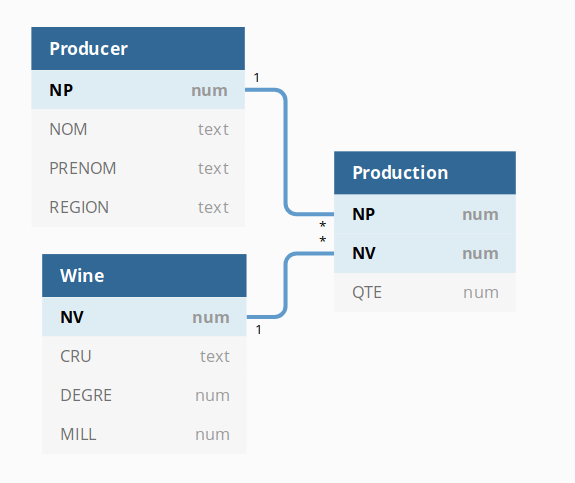

In [7]:
from IPython.display import Image
Image("table_1.png")

#### Exercise 1.2

Convert table **Master2** to the Second Normal Form (2NF) or Third Normal Form (3NF) as applicable.
* Explain your answer
* List main functional dependencies (not all of them)
* Describe the schema of new tables and how they relate
  * You can write Tables as above or you can insert images in the notebook.

**Note:** For this part, consider that a wine can be bought in multiple locations and multiple times per day.

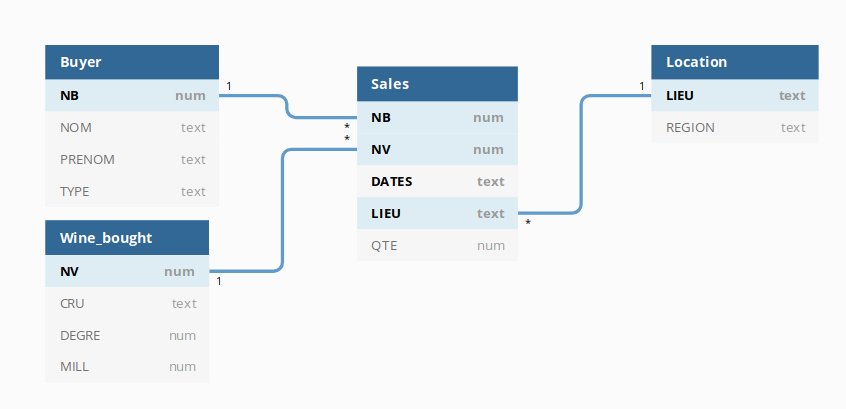

In [8]:
from IPython.display import Image
Image("table_2.png")

Once you have defined the 2NF or 3NF (as applicable) we need to split the data into new tables.

A table can be created from the result of a query.

In the following example we will create a new table "dummy" to store the different values of alcohol content.

In [9]:
%%sql DROP TABLE IF EXISTS dummy;

-- Create dummy table
CREATE TABLE dummy AS
SELECT DISTINCT DEGRE
FROM MASTER1;

 * sqlite:///wine.db
Done.
Done.


[]

In [10]:
print("\nContent of the database")
printSchema(conn)


Content of the database
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)
dummy:
  0: DEGRE(NUM)


In [11]:
%%sql
SELECT *
FROM dummy;

 * sqlite:///wine.db
Done.


DEGRE
None
11.5
11.3
12.1
10.9
11.7
11.2
12.3
11.9
11.8


Looking into "dummy", we notice that our query includes NULL. This is not allowed if we were to use DEGRE as key for a table.

To correct this, we need to change the query to explicitly test for NULL as follows:

In [37]:
%%sql DROP TABLE IF EXISTS dummy;

-- Create dummy table
CREATE TABLE dummy AS
SELECT DISTINCT DEGRE
FROM MASTER1
WHERE DEGRE IS NOT NULL;

SELECT *
FROM dummy;

 * sqlite:///wine.db
Done.
Done.
Done.


DEGRE
11.5
11.3
12.1
10.9
11.7
11.2
12.3
11.9
11.8
10.7


Notice that we use `NULL` given that `None` is only used for display.

In [ ]:
# Remove "dummy" table
%sql DROP TABLE IF EXISTS dummy;

#### Exercise 1.3

Create the new tables from Master1:

In [29]:
%%sql DROP TABLE IF EXISTS Producer;

-- Create Producer table
CREATE TABLE Producer AS
SELECT DISTINCT NP, NOM, PRENOM, REGION
FROM MASTER1
WHERE NP IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

In [45]:
%%sql DROP TABLE IF EXISTS Wine;

-- Create Wine table
CREATE TABLE Wine AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER1
WHERE NV IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

In [46]:
%%sql DROP TABLE IF EXISTS Production;

-- Create Production table
CREATE TABLE Production AS
SELECT DISTINCT NP, NV, QTE
FROM MASTER1
WHERE NP IS NOT NULL AND NV IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

#### Exercise 1.4

Create the new tables from Master2:

In [39]:
%%sql DROP TABLE IF EXISTS Buyer;

-- Create Buyer table
CREATE TABLE Buyer AS
SELECT DISTINCT NB, NOM, PRENOM, TYPE
FROM MASTER2
WHERE NB IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

In [40]:
%%sql DROP TABLE IF EXISTS Location;

-- Create Location table
CREATE TABLE Location AS
SELECT DISTINCT LIEU, REGION
FROM MASTER2
WHERE LIEU IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

In [48]:
%%sql DROP TABLE IF EXISTS Sales;

-- Create Sales table
CREATE TABLE Sales AS
SELECT DISTINCT NB, NV, DATES, LIEU, QTE
FROM MASTER2
WHERE NB IS NOT NULL AND NV IS NOT NULL AND DATES IS NOT NULL AND LIEU IS NOT NULL;


 * sqlite:///wine.db
Done.
Done.


[]

In [49]:
%%sql DROP TABLE IF EXISTS Wine_bought;

-- Create Wine_bought table
CREATE TABLE Wine_bought AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER2
WHERE NV IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

# PART II: SQL QUERIES

In the second part of this TP you will create SQL queries to retrieve information from the database.

**Important:**

- You MUST use the normalized tables created in previous steps.
  - The normalized tables will also be used in TP3.
- Do NOT use **Master1** and **Master2** in your queries.

#### Exercise 2.1

What are the different types of clients (buveurs) by volume of purchases?

In [51]:
%%sql
SELECT DISTINCT TYPE as Type_of_buveurs 
FROM Buyer;

 * sqlite:///wine.db
Done.


Type_of_buveurs
petit
moyen
gros


#### Exercise 2.2

What regions produce Pommard or Brouilly?

In [52]:
%%sql
Select  CRU, REGION
FROM Production 
JOIN Wine on Wine.NV=Production.NV
JOIN Producer on Producer.NP=Production.NP

WHERE CRU in ("Pommard", "Brouilly");

 * sqlite:///wine.db
Done.


CRU,REGION
Pommard,Bourgogne
Pommard,Rhone
Brouilly,Bourgogne


#### Exercise 2.3

What regions produce Pommard and Brouilly?

In [53]:
%%sql
SELECT REGION
FROM Production 
    JOIN Wine on Wine.NV=Production.NV
    JOIN Producer on Producer.NP=Production.NP
WHERE CRU = "Pommard" 

INTERSECT

SELECT REGION 
FROM Production    
    JOIN Wine on Wine.NV=Production.NV
    JOIN Producer on Producer.NP=Production.NP
WHERE CRU = "Brouilly";

 * sqlite:///wine.db
Done.


REGION
Bourgogne


#### Exercise 2.4

Get the number of wines bught by CRU and Millésime

In [55]:
%%sql
SELECT CRU, MILL, SUM(QTE) as "Number_of_wines_bought"
FROM Sales 
    JOIN Wine ON Sales.NV = Wine.NV
WHERE QTE is NOT NULL
GROUP BY CRU, MILL
Order by CRU, MILL DESC;

 * sqlite:///wine.db
Done.


CRU,MILL,Number_of_wines_bought
Arbois,1980,8
Auxey Duresses,1914,80
Beaujolais Primeur,1983,7
Beaujolais Villages,1979,520
Beaujolais Villages,1978,130
Beaujolais Villages,1976,120
Beaujolais Villages,1975,10
Chapelle Chambertin,1973,30
Chateau Corton Grancey,1980,4
Chenas,1984,1


#### Exercise 2.5

Retrieve the wine number (NV) of wines produced by more than three producers

In [56]:
%%sql
SELECT Wine.NV , Count(Producer.NP) as "Number_of_producers"

FROM Production 
    JOIN Wine on Wine.NV=Production.NV
    JOIN Producer on Producer.NP=Production.NP

GROUP BY Wine.NV
HAVING (Number_of_producers > 3);

 * sqlite:///wine.db
Done.


NV,Number_of_producers
45,5
78,5
89,4
98,5


#### Exercise 2.6

Which producers have not produced any wine?

In [59]:
%%sql
SELECT Producer.NP, Producer.NOM, Producer.PRENOM

FROM Producer
    LEFT JOIN Production on Production.NP = Producer.NP 
Group BY Producer.NP
Having Count(distinct Production.NV) =0;



 * sqlite:///wine.db
Done.


NP,NOM,PRENOM
3,Six,Paul
6,Marmagne,Bernard
8,Lioger d'Harduy,Gabriel
16,Barbin,Bernard
17,Faiveley,Guy
18,Tramier,Jean
19,Dupaquier,Roger
20,Lamy,Jean
21,Cornu,Edmond
26,Violot,Gilbert


#### Exercise 2.7

What clients (buveurs) have bought at least one wine from 1980?

In [58]:
%%sql
SELECT Distinct Buyer.NB, Buyer.NOM, Buyer.PRENOM

FROM Sales 
    JOIN Wine_bought on Wine_bought.NV = Sales.NV 
    JOIN Buyer on Buyer.NB=Sales.NB

WHERE Wine_bought.MILL = 1980

ORDER BY Buyer.NB;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
2,Artaud,Antonin
8,Aragon,Louis
44,Gide,Andre
45,Giono,Jean
50,Lautreamont,None
61,Mallarme,Stephane


#### Exercise 2.8

What clients (buveurs) have NOT bought any wine from 1980?

In [61]:
%%sql
SELECT distinct Buyer.NB, Buyer.NOM, Buyer.PRENOM

FROM Wine_bought
     LEFT JOIN Sales on Wine_bought.NV = Sales.NB 
     LEFT JOIN Buyer on Sales.NB=Buyer.NB

WHERE Buyer.NB not in ( SELECT Sales.NB
                        FROM Sales
                        JOIN Wine_bought on Wine_bought.NV = Sales.NV  
                        WHERE Wine_bought.MILL = 1980);



 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
1,Aristote,None
3,Aron,Raymond
4,Apollinaire,Guillaume
5,Audiberti,Jacques
6,Arrabal,Fernando
7,Anouilh,Jean
9,Ajar,Emile
10,Andersen,Yann
12,Bataille,Georges
14,Bory,Jean Louis


#### Exercise 2.9

What clients (buveurs) have bought ONLY wines from 1980?

In [62]:
%%sql
SELECT Distinct Buyer.NB, Buyer.NOM, Buyer.PRENOM

FROM Sales 
    JOIN Wine_bought on Wine_bought.NV = Sales.NV 
    JOIN Buyer on Buyer.NB=Sales.NB

WHERE Wine_bought.MILL = 1980 
and Buyer.NB not in (SELECT Buyer.NB                   
                     FROM Sales 
                         JOIN Wine_bought on Wine_bought.NV = Sales.NV 
                         JOIN Buyer on Buyer.NB=Sales.NB
                     WHERE Wine_bought.MILL <> 1980)

ORDER BY Buyer.NB;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
44,Gide,Andre
45,Giono,Jean
50,Lautreamont,None


#### Exercise 2.10

List all wines from 1980

In [63]:
%%sql
SELECT Distinct NV, CRU,MILL, DEGRE
FROM Wine
Where MILL = 1980;

 * sqlite:///wine.db
Done.


NV,CRU,MILL,DEGRE
1,Mercurey,1980,11.5
4,Mercurey,1980,10.9
16,Meursault,1980,12.1
20,Cote de Brouilly,1980,12.1
26,Chateau Corton Grancey,1980,None
28,Volnay,1980,11
43,Fleurie,1980,11.4
74,Arbois,1980,12
78,Etoile,1980,12
79,Seyssel,1980,11


#### Exercise 2.11

What are the wines from 1980 bought by NB=2?

In [66]:
%%sql
SELECT Distinct Wine_bought.NV, CRU,MILL, DEGRE
FROM Wine_bought
    JOIN Sales on Wine_bought.NV = Sales.NV
    JOIN Buyer on Sales.NB = Buyer.NB

WHERE MILL = 1980 and Buyer.NB = 2;


 * sqlite:///wine.db
Done.


NV,CRU,MILL,DEGRE
1,Mercurey,1980,11.5


#### Exercise 2.12

What clients (buveurs) have bought ALL the wines from 1980?

In [67]:
%%sql
SELECT Buyer.NB, NOM, PRENOM, Wine_bought.Mill

FROM Sales 
JOIN Wine_bought on Wine_bought.NV = Sales.NV 
JOIN Buyer on Buyer.NB=Sales.NB

GROUP BY Buyer.NB
HAVING Wine_bought.MILL = 1980 
and Count(distinct Wine_bought.NV) = (SELECT Count(NV)
                                     FROM Wine
                                     Where Mill = 1980)





 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,MILL
44,Gide,Andre,1980
